## Task d

Frederik Rogge, Mouhammad Abu Rasheed and Homa Priya Tarigopula

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
import os
from mpl_toolkits import mplot3d
%matplotlib inline
%matplotlib notebook


from utils import *
from resampling import *
from models import *

np.random.seed(0)

<IPython.core.display.Javascript object>


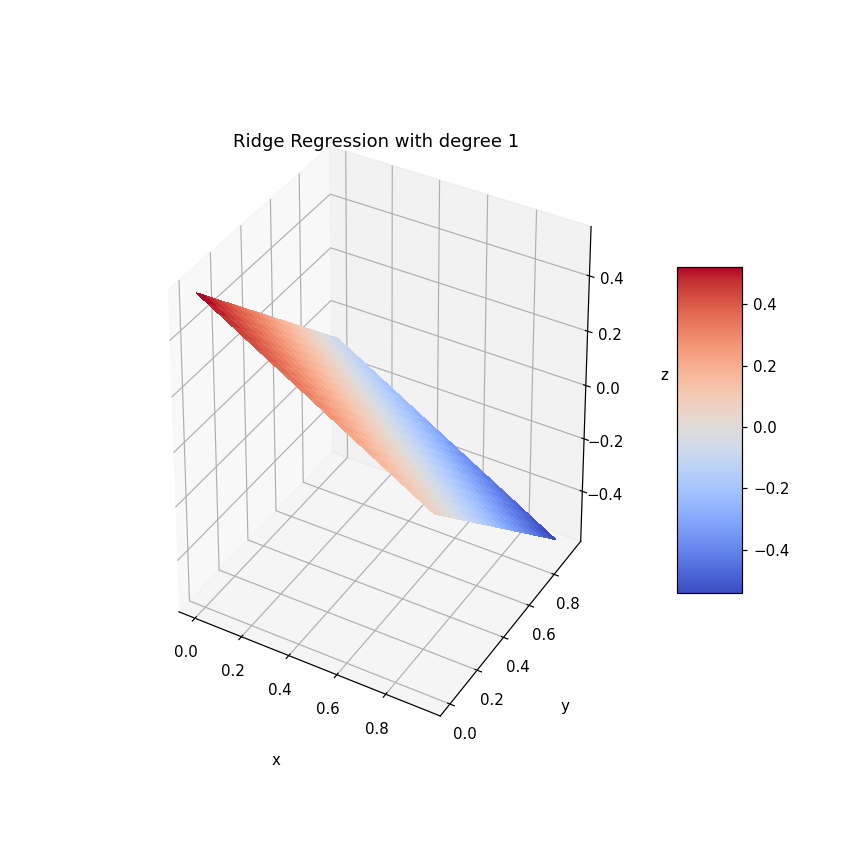

<IPython.core.display.Javascript object>


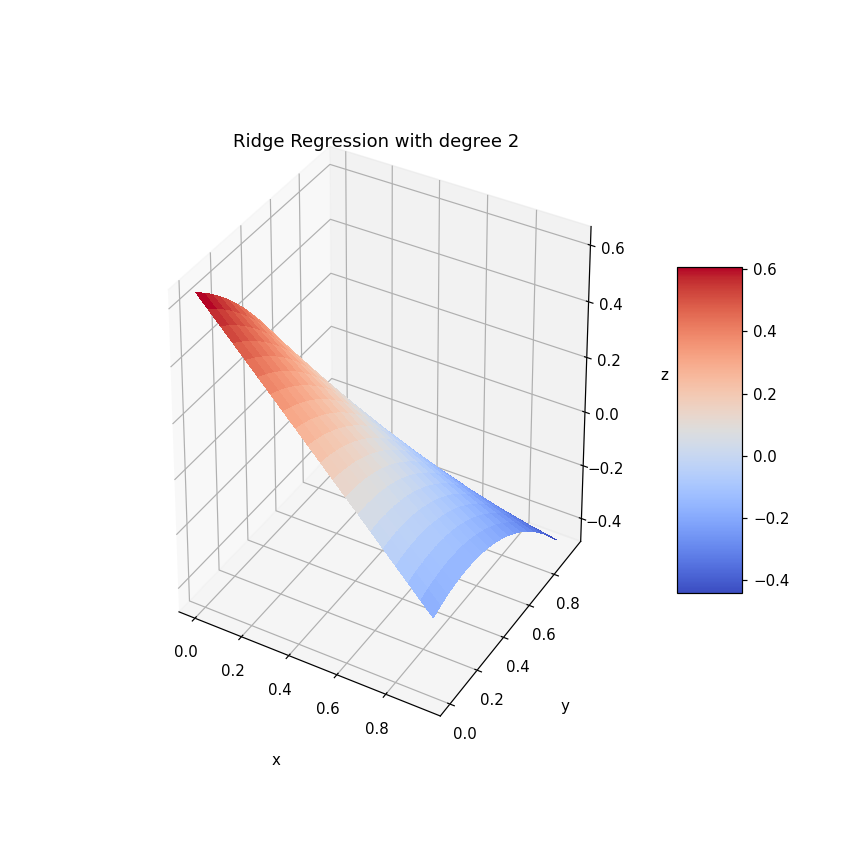

<IPython.core.display.Javascript object>


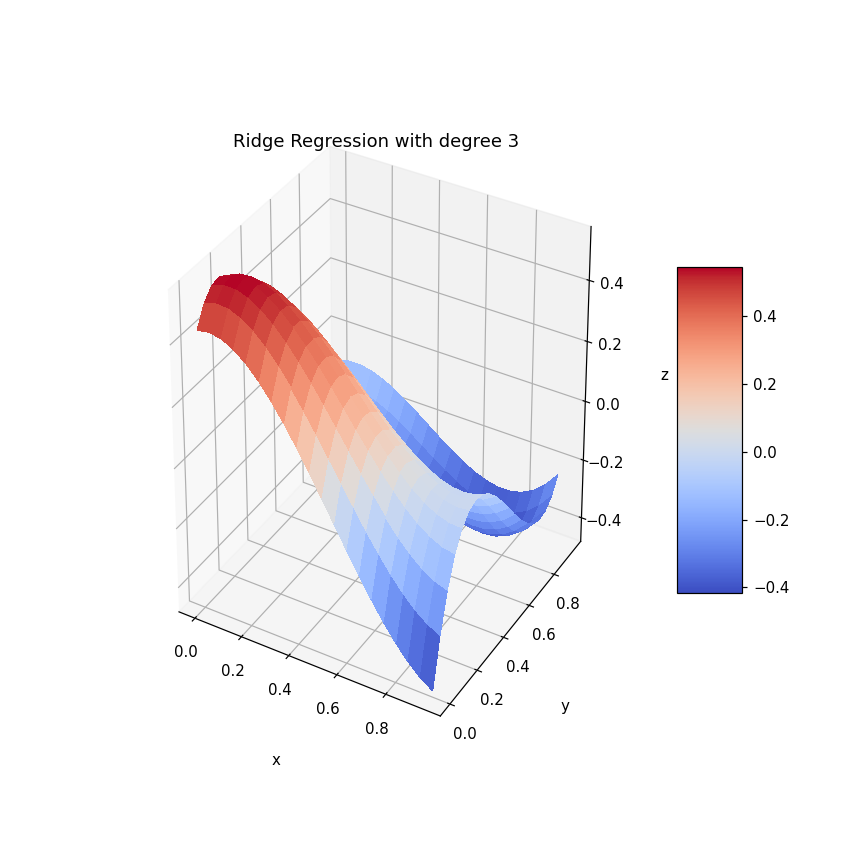

<IPython.core.display.Javascript object>


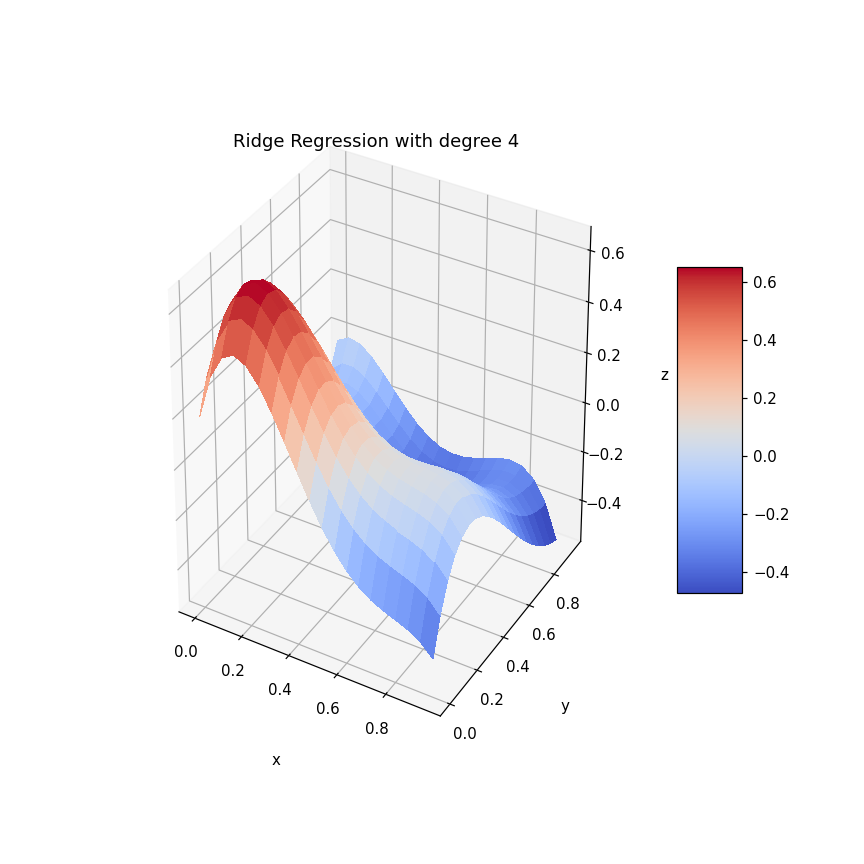

<IPython.core.display.Javascript object>


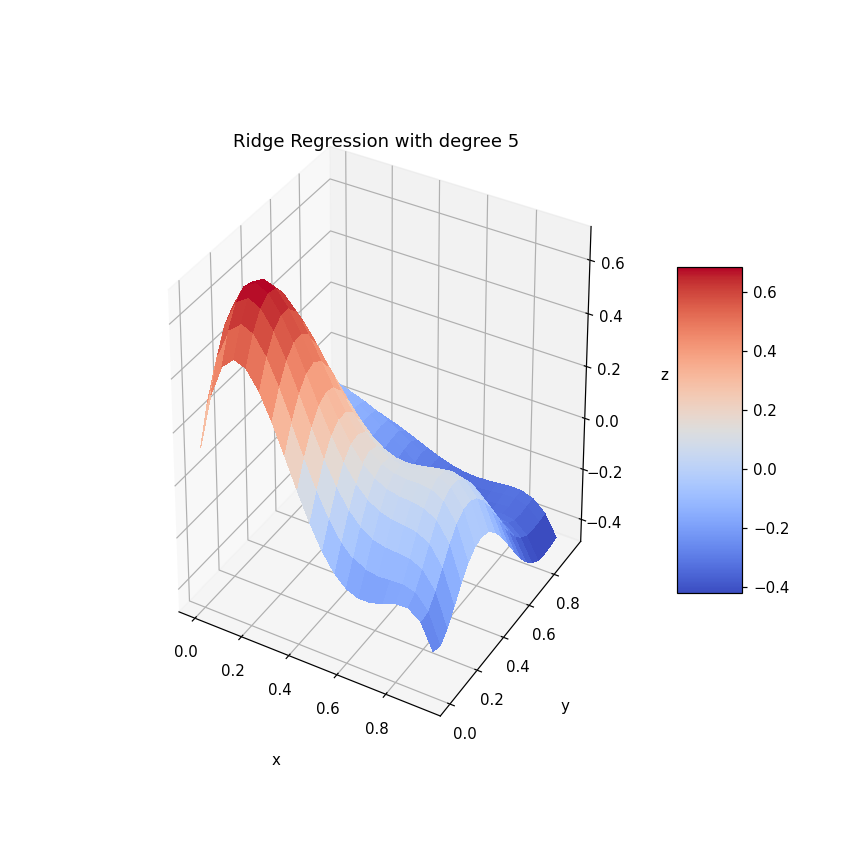

In [2]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def R2(y, y_hat):
    return 1 - np.sum((y - y_hat)**2) / np.sum((y - np.mean(y))**2)

def MSE(y, y_hat):
    return np.mean(np.square(y - y_hat))

def z_score(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def Ridge(x, y, l):
    beta = np.linalg.pinv(x.T @ x + l*np.identity(x.shape[1]) ) @ x.T @ y
    return beta


# Create data
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)

x, y = np.meshgrid(x,y)


# Create features as pairs of (x, y)
features = np.stack([x.ravel(), y.ravel()], axis=1)

# Compute z
z = FrankeFunction(x, y)

# Get labels
labels = z.ravel()
labels = labels.reshape((-1,1))

# Split dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=20)

degree = [1, 2, 3, 4, 5]

#1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001,
Lambda = [ 0.00001]

for n_l, l in enumerate(Lambda):  
    for d in degree:
        # Create the matrix of features
        poly = PolynomialFeatures(degree = d,include_bias= False )
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        features_poly = poly.fit_transform(features)
        
        # Scaling data
        scaler = StandardScaler(with_std=True)
        x_train_scaled =scaler.fit_transform(x_train_poly)
        x_test_scaled = scaler.transform(x_test_poly)
        features_scaled = scaler.transform(features_poly)
        
        # Determine optimal parameters with ridge regression
        beta = Ridge(x_train_scaled, y_train, l )
        
        Y_hat = features_scaled @ beta
        
        fig = plt.figure(figsize=(8, 8))
        ax = plt.axes(projection='3d')
        surf = ax.plot_surface(x, y, Y_hat.reshape(x.shape), cmap = plt.cm.coolwarm, linewidth=0, antialiased=False)
        fig.colorbar(surf, shrink=0.5, aspect=5)
        ax.set_title('Ridge Regression with degree '+ str(d))
        ax.set_xlabel('x', labelpad=20)
        ax.set_ylabel('y', labelpad=20)
        ax.set_zlabel('z', labelpad=20)

        plt.show()

### a.)  Bootstrap

In [3]:
def bootstrap(features, labels ,n_datapoints , degree_values, include_intercept = False , scaling= True , add_noise= True, mean = 0, std = 1, solver = LinearRegression, n_bootstraps = 1000,**solver_args):
  
    Maxpolydegree = np.max(degree_values)

    error_test = np.zeros((Maxpolydegree,  len(n_datapoints)))
    bias_test = np.zeros((Maxpolydegree,  len(n_datapoints)))
    variance_test = np.zeros((Maxpolydegree,  len(n_datapoints)))

    error_train = np.zeros((Maxpolydegree,  len(n_datapoints)))
    bias_train = np.zeros((Maxpolydegree,  len(n_datapoints)))
    variance_train = np.zeros((Maxpolydegree,  len(n_datapoints)))

    if add_noise :
        np.random.seed(1)
        labels_n = labels +  np.random.normal(mean, std, labels.shape )
    else :
        labels_n = labels
    
    # Hold out some test data that is never used in training.
    Xtrain, X_test, ytrain, y_test = train_test_split(features, labels_n, 
                                                        test_size=0.2, random_state = 2021)
   
    for n,k in enumerate(n_datapoints) :
      
        chosen_indices = np.random.choice(len(ytrain), int(k*len(ytrain)), replace=False)
        
        # choosing a  subset of train data points
        X_train, y_train =  Xtrain[chosen_indices], ytrain[chosen_indices]
    
        for nd, degree in enumerate(degree_values):
            # Input features transformation 
            poly = PolynomialFeatures(degree = degree, include_bias=not include_intercept)
            x_train = poly.fit_transform(X_train)
            x_test = poly.fit_transform(X_test)

            if scaling:
                # Scale data
                scaler = StandardScaler(with_std=True)
                x_train= scaler.fit_transform(x_train)
                x_test = scaler.transform(x_test)
            else:
                x_train = x_train
                x_test = x_test
                
            bs = Bootstrap()
                    
            error_test[nd,n], bias_test[nd,n], variance_test[nd,n], error_train[nd,n], bias_train[nd,n], variance_train[nd,n] = bs.resample(x_train, x_test, y_train, y_test, solver, n_bootstraps= n_bootstraps,**solver_args)
            
            #print('Polynomial degree:', degree)
            #print('Error:', error_test[nd,n])
            #print('Bias^2:', bias_test[nd,n])
            #print('Var:', variance_test[nd,n])
            #print('{} >= {} + {} = {}'.format(error_test[nd,n], bias_test[nd,n], variance_test[nd,n], bias_test[nd,n]+variance_test[nd,n]))

    return error_test, bias_test, variance_test,error_train , bias_train , variance_train 


In [4]:
def gen_plot(n_datapoints, polynomial, estimated_mse, title , legend_label, fig_name):
    fig, ax = plt.subplots()
    for n,k in enumerate(n_datapoints):
        ax.plot(polynomial, np.log10(estimated_mse[:, n]), label= legend_label +', % of train data = '+ str(k)  )
        ax.set_xlabel('Polynomial degree')
        ax.set_ylabel('-np.log10[MSE]')
        ax.set_xticks(polynomial)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        save_fig(fig , name =fig_name + legend_label )
    ax.set_title(title)
    plt.show()
    
    

In [5]:
n_bootstraps = 100
degree_values = np.arange(1, 25)  # Specify degree of polynomial to be fitted

n_datapoints = [0.5, 0.75, 1.0]

Lambda = [1e0, 1e-1, 1e-2, 1e-3 ]    # different values of Lambda

<IPython.core.display.Javascript object>


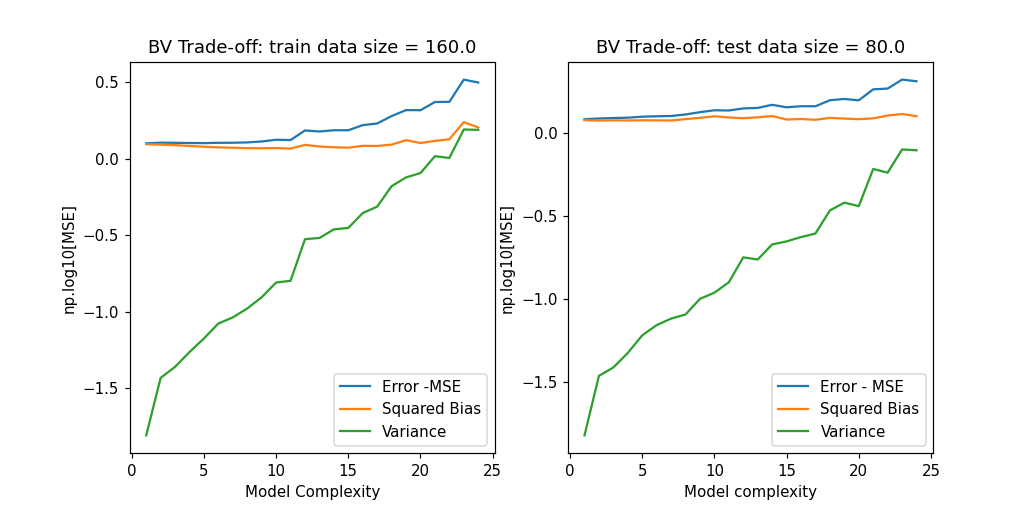

<IPython.core.display.Javascript object>


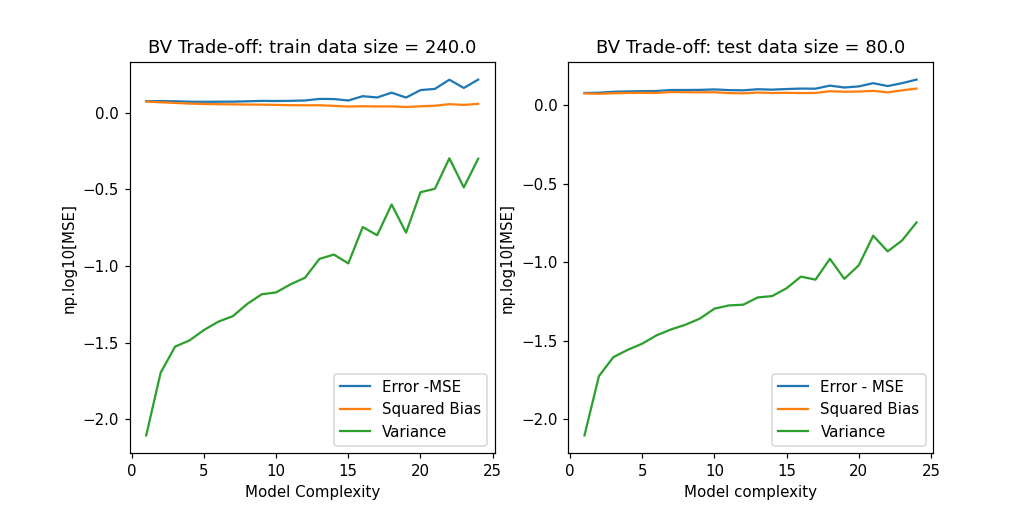

<IPython.core.display.Javascript object>


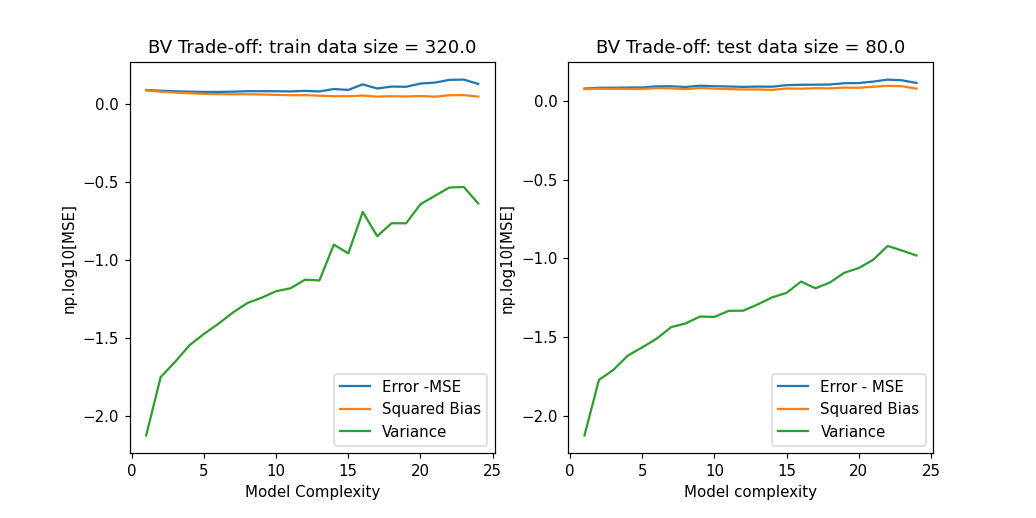

<IPython.core.display.Javascript object>


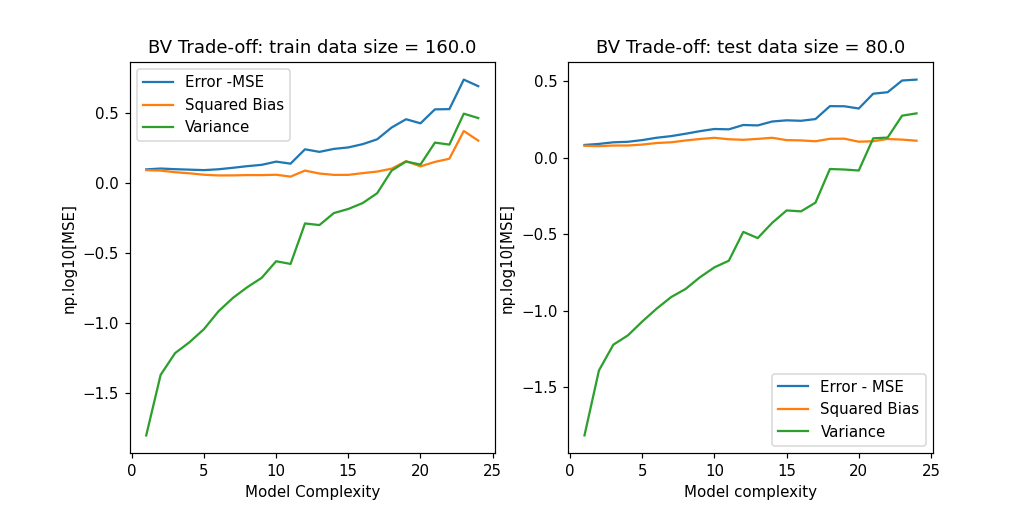

<IPython.core.display.Javascript object>


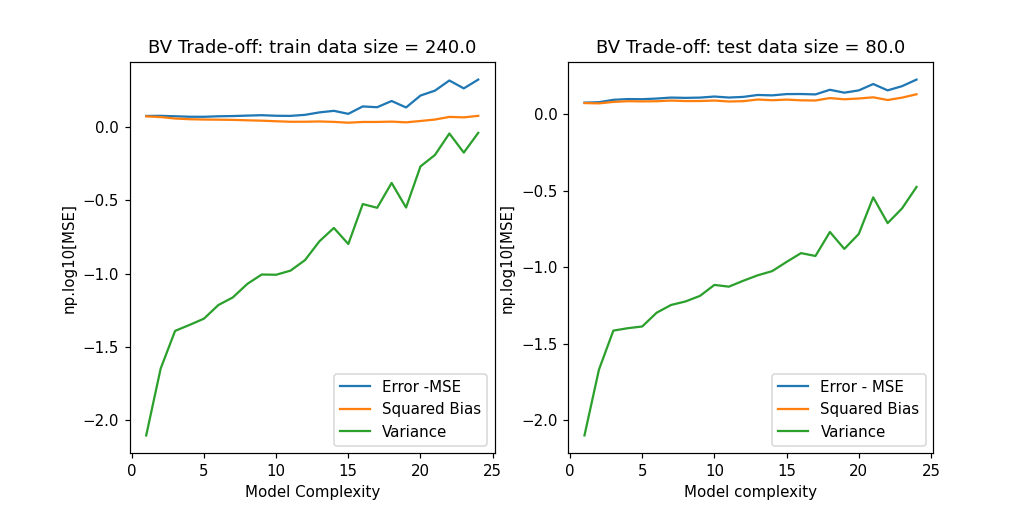

<IPython.core.display.Javascript object>


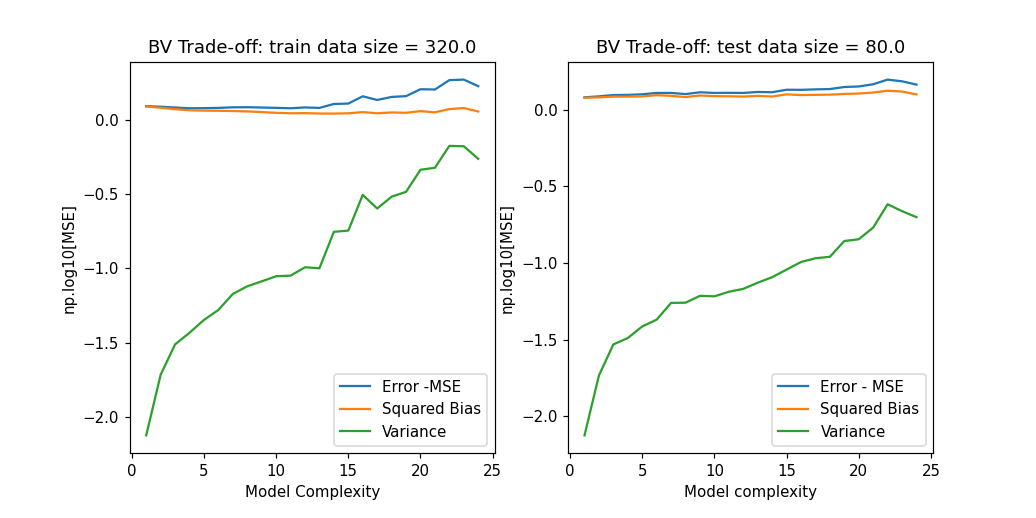

<IPython.core.display.Javascript object>


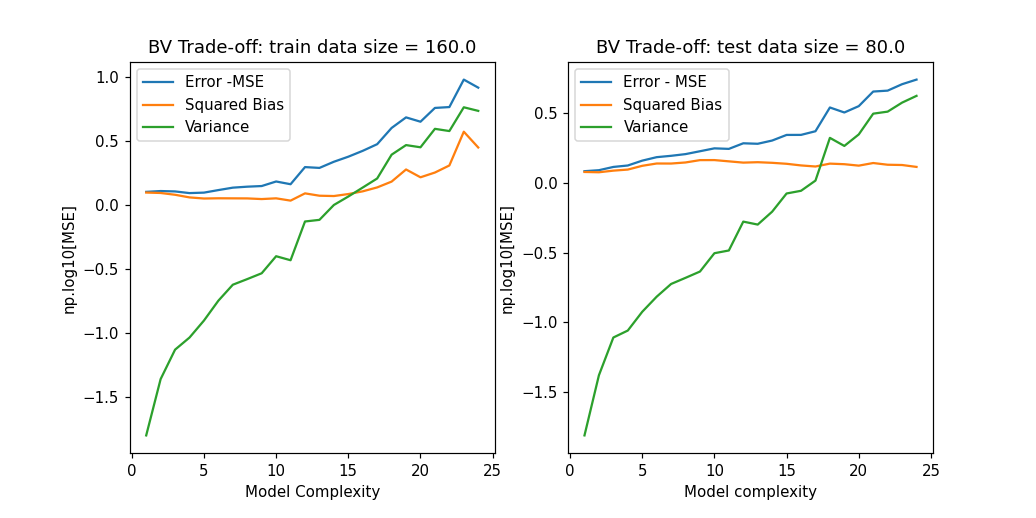

<IPython.core.display.Javascript object>


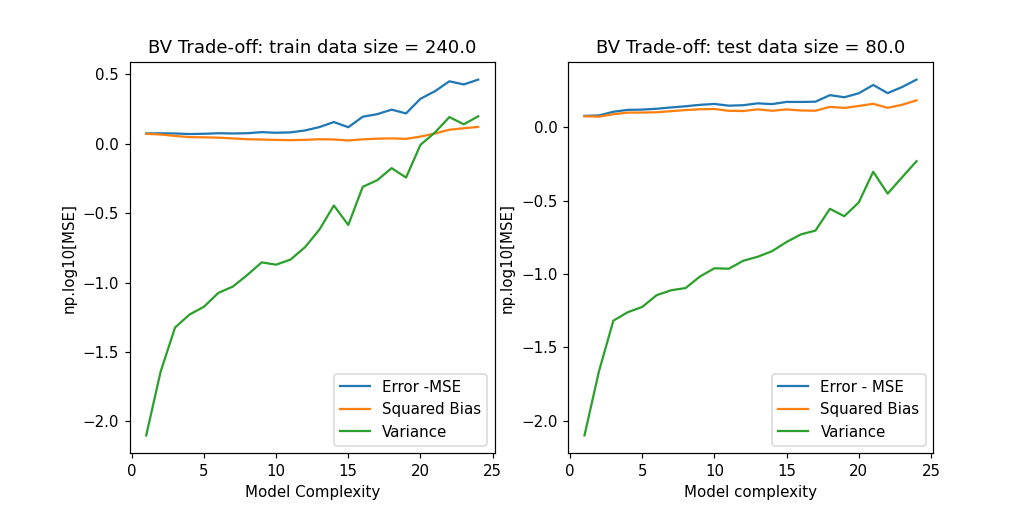

<IPython.core.display.Javascript object>


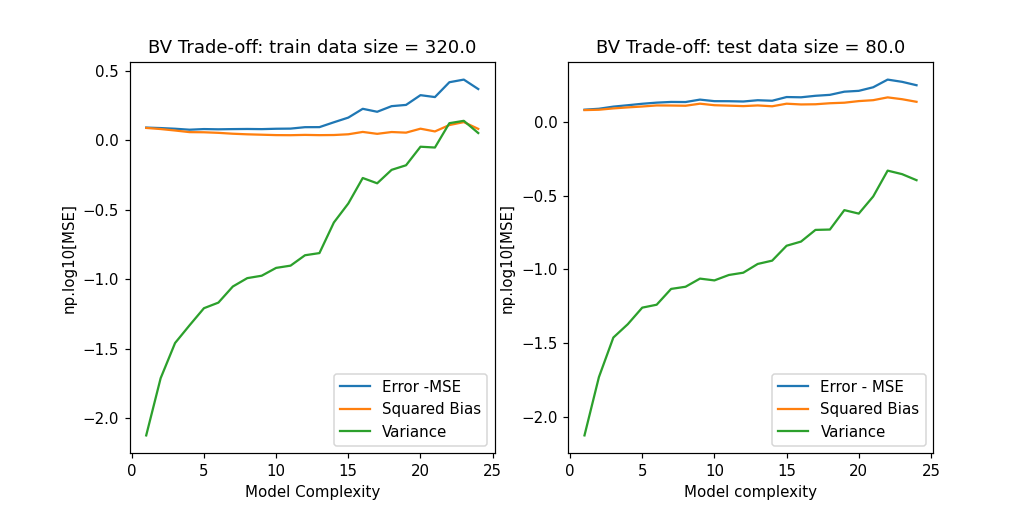

<IPython.core.display.Javascript object>


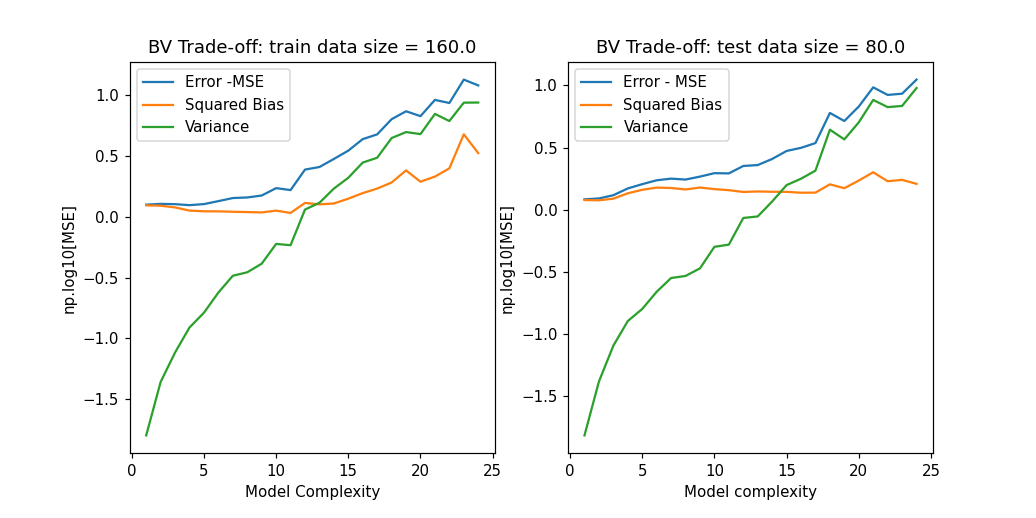

<IPython.core.display.Javascript object>


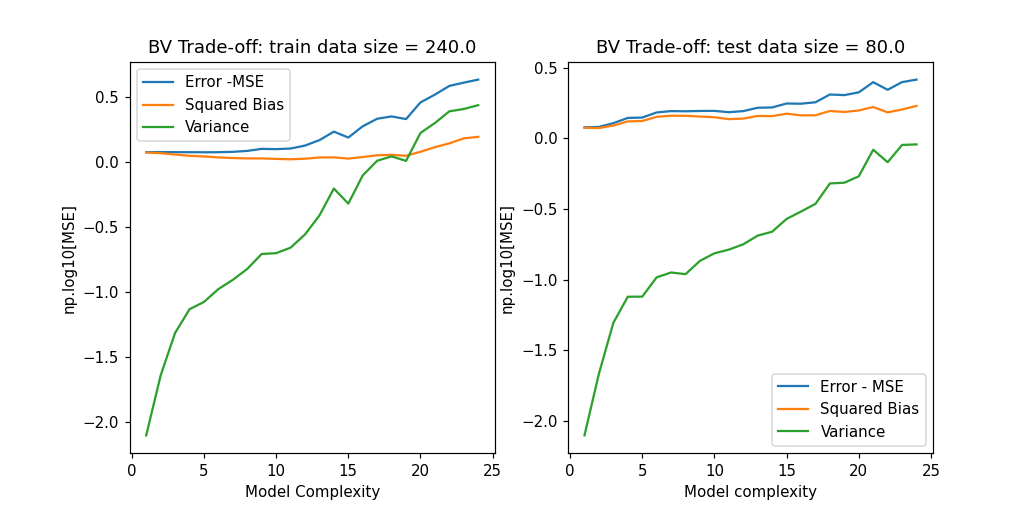

<IPython.core.display.Javascript object>


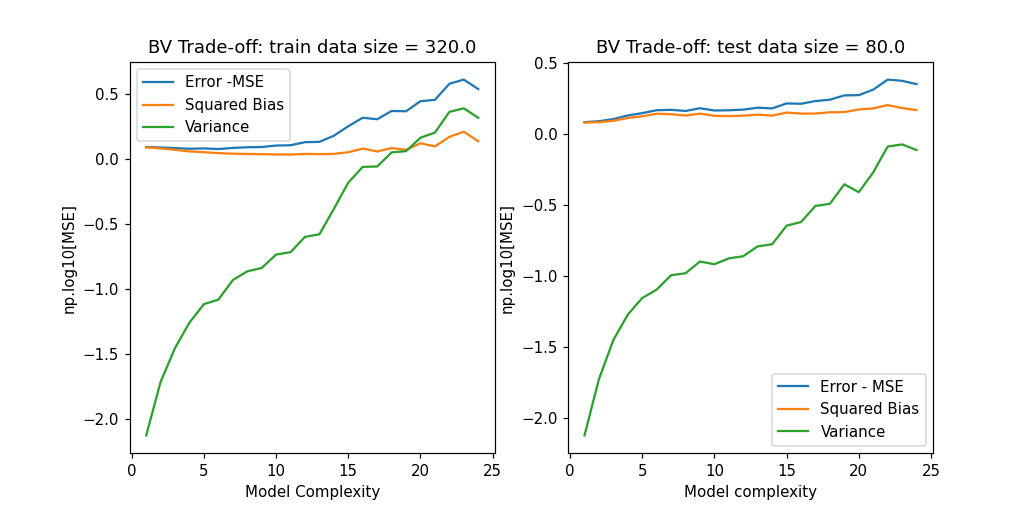

In [6]:
Maxpolydegree = np.max(degree_values)
polynomial = np.zeros(Maxpolydegree)

for polydegree in range(1, Maxpolydegree+1):
    polynomial[polydegree-1] = polydegree
    
# define the model we want to use 
solver = RidgeRegression

for lbd in Lambda:

    #define the input argumets for the solver 
    solver_args ={ 'fit_intercept': False, 'lbd': lbd}


    error_test, bias_test, variance_test,error_train , bias_train , variance_train = bootstrap(features, labels , n_datapoints, degree_values, 
                              include_intercept= False , scaling= True , add_noise= True, mean = 0, std = 1,
                             solver= solver,  n_bootstraps= n_bootstraps, **solver_args)

    # plot bias-variance tradeoff
    for n,k in enumerate(n_datapoints): 
        f, (ax0, ax1) = plt.subplots(1, 2, figsize=(4.8*2, 4.8))

        ax0.plot(polynomial, np.log10(error_train[:, n]), label= 'Error -MSE')
        ax0.plot(polynomial, np.log10(bias_train[:, n]), label= 'Squared Bias')
        ax0.plot(polynomial, np.log10(variance_train[:, n]), label= 'Variance')
        ax0.set_xlabel('Model Complexity')
        ax0.set_ylabel('np.log10[MSE]')
        ax0.legend()
        ax0.set_title('BV Trade-off: train data size = '+str(np.round(k*0.8*len(labels), 2)))

        ax1.plot(polynomial, np.log10(error_test[:, n]), label= 'Error - MSE')
        ax1.plot(polynomial, np.log10(bias_test[:, n]), label= 'Squared Bias')
        ax1.plot(polynomial, np.log10(variance_test[:, n]), label= 'Variance')
        ax1.set_xlabel('Model complexity')
        ax1.set_ylabel('np.log10[MSE]')
        ax1.legend()
        ax1.set_title('BV Trade-off: test data size = '+str(np.round(0.2*len(labels), 2)))

        save_fig(f, name ='d_bv_tradeoff_n_'+str(int(k*0.8*len(labels)))+'Lambda-'+str(lbd)+'.png')

## b.) Cross-validation

In [7]:
k_values  = [5, 6, 7,8, 9, 10]  # Number of folds

degree_values = np.arange(1, 5)  # Specify degree of polynomial to be fitted

Lambda = [1e0, 1e-1, 1e-2, 1e-3 ]    # different values of Lambda

# define the model we want to use 
solver = RidgeRegression

In [8]:
def gen_plot_kfold(n_datapoints, polynomial, estimated_mse, title , y_label, legend_label, fig_name):
    fig, ax = plt.subplots()
    for n,k in enumerate(n_datapoints):
        ax.plot(polynomial, np.log10(estimated_mse[:, n]), label= legend_label +', k = '+ str(k)  )
        ax.set_xlabel('Polynomial degree')
        ax.set_ylabel( y_label)
        ax.set_xticks(polynomial)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        save_fig(fig , name =fig_name+ legend_label+'.png' )
    ax.set_title(title)
    plt.show()

In [9]:
def plot_kfold_implementation(features, labels , k_values, degree_values, fig_name, solver = LinearRegression,
                              scaling= True , add_noise= True, mean = 0, std = 1, **solver_args):
    
    Maxpolydegree = np.max(degree_values)
    polynomial = np.zeros(Maxpolydegree)
    estimated_train_mse = np.zeros((Maxpolydegree,  len(k_values)))
    estimated_test_mse = np.zeros((Maxpolydegree,len(k_values)))

    if add_noise :
        np.random.seed(1)
        labels_n = labels +  np.random.normal(mean, std, labels.shape )
    else :
        labels_n = labels
    

    for polydegree in range(1, Maxpolydegree+1):
        polynomial[polydegree-1] = polydegree
        
    for degree in degree_values:
        # fit polynomials on test and train
        poly = PolynomialFeatures(degree, include_bias=not scaling)
        features_poly = poly.fit_transform(features)

        if scaling:
            # Scale data
            scaler = StandardScaler(with_std=True)
            feature_scale = scaler.fit_transform(features_poly)
            
        for n,k in enumerate(k_values):
            
            kf = KFoldCV()      #Implementation from resampling.py
            
            test_MSE, train_MSE = kf.cv(feature_scale, labels_n , degree, k, scaling = scaling,  solver = solver, **solver_args )
            
            #print(test_MSE)

            estimated_train_mse[degree-1, n] = np.mean(train_MSE)
            estimated_test_mse[degree-1, n] = np.mean(test_MSE)

    print('MSE on test-set : \n',estimated_test_mse)

    #gen_plot_kfold(k_values, polynomial, estimated_train_mse,
    #         title = 'k-fold cv implementation for different order polynomials' ,
    #        y_label = 'MSE',
    #        legend_label = 'Train Error', fig_name = fig_name)

    gen_plot_kfold(k_values, polynomial, estimated_test_mse,
             title = 'k-fold cv implementation for different order polynomials' ,
             y_label = 'MSE',
            legend_label = 'Test Error', fig_name = fig_name)
    
    return estimated_test_mse
    

### With noise 

MSE on test-set : 
 [[1.34530202 1.31655465 1.30809294 1.30493692 1.28726237 1.28154276]
 [1.90550206 1.69175077 1.61402569 1.55998227 1.46644063 1.4319952 ]
 [2.21292947 1.92444748 1.81872408 1.74793319 1.60018489 1.52689483]
 [2.53936926 2.24043764 2.11510763 2.03286335 1.80686349 1.65401852]]


<IPython.core.display.Javascript object>


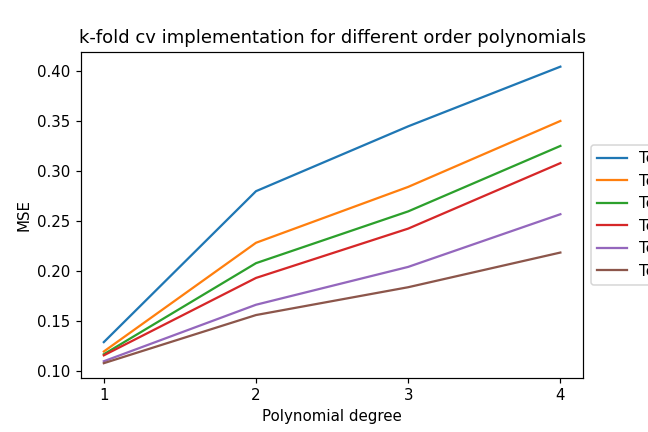

MSE on test-set : 
 [[1.34582139 1.31690809 1.30841798 1.30523721 1.28748886 1.28173294]
 [1.98834198 1.74852148 1.65592581 1.59274536 1.48848555 1.44895731]
 [2.75112271 2.39743148 2.20740133 2.08484458 1.83039597 1.69013409]
 [3.0613456  2.73026783 2.57020278 2.43037352 2.08976788 1.84506914]]


<IPython.core.display.Javascript object>


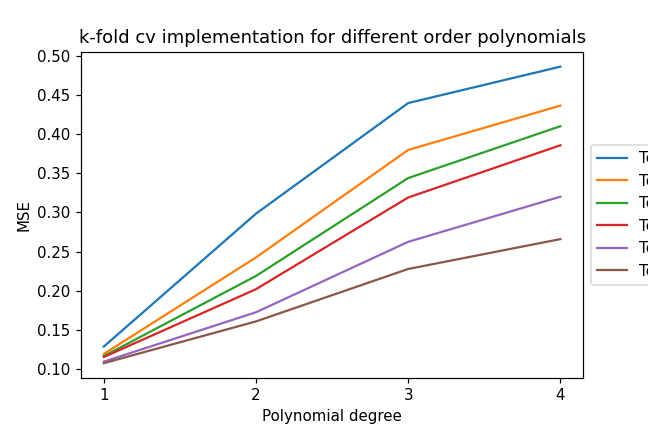

MSE on test-set : 
 [[1.34587365 1.31694366 1.30845068 1.30526743 1.28751166 1.28175208]
 [1.9980531  1.75517694 1.66076801 1.5965122  1.49099735 1.45086905]
 [3.04544623 2.69108764 2.44387571 2.2900454  1.96835524 1.78489685]
 [3.73312039 3.40085252 3.30623014 3.10871161 2.66967474 2.27424329]]


<IPython.core.display.Javascript object>


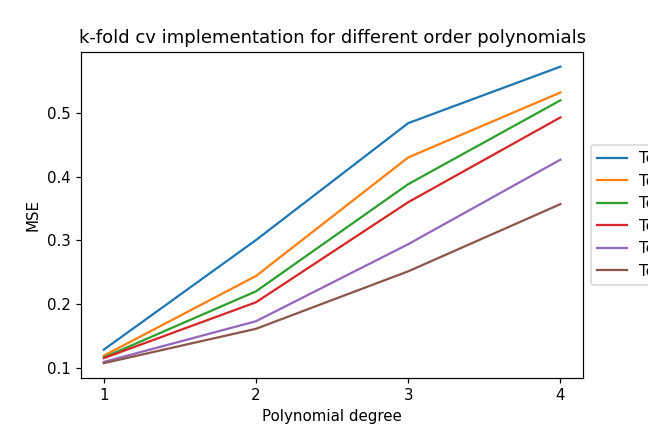

MSE on test-set : 
 [[1.34587888 1.31694722 1.30845396 1.30527045 1.28751394 1.281754  ]
 [1.99904104 1.755854   1.66125978 1.59689454 1.49125204 1.45106266]
 [3.09082568 2.73742574 2.48047344 2.32183056 1.98956367 1.79911502]
 [4.24676234 4.06575926 4.03401379 3.86370618 3.32655108 2.74061436]]


<ipython-input-8-7a78d83b1965>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


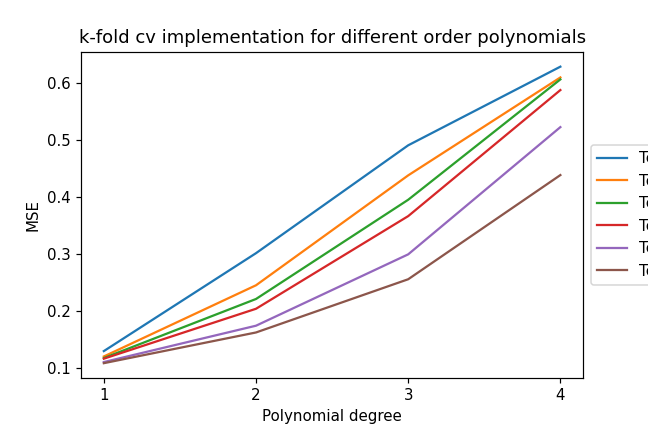

In [10]:
for lbd in Lambda:
    
    #define the input argumets for the solver 
    solver_args ={ 'fit_intercept': False, 'lbd': lbd}
    
    plot_kfold_implementation(features, labels ,k_values, degree_values, fig_name ='d_kfold_withnoise_lbd-'+str(lbd), solver = solver, **solver_args) 

### Without noise

MSE on test-set : 
 [[0.32306449 0.29866109 0.27871902 0.26818856 0.25758534 0.24941111]
 [0.75535944 0.6052048  0.49784931 0.43639985 0.38333711 0.35207018]
 [0.98642215 0.78568198 0.64547993 0.54800501 0.46471962 0.42150261]
 [1.24309333 1.03351581 0.85109156 0.71977045 0.58769055 0.51649392]]


<ipython-input-8-7a78d83b1965>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


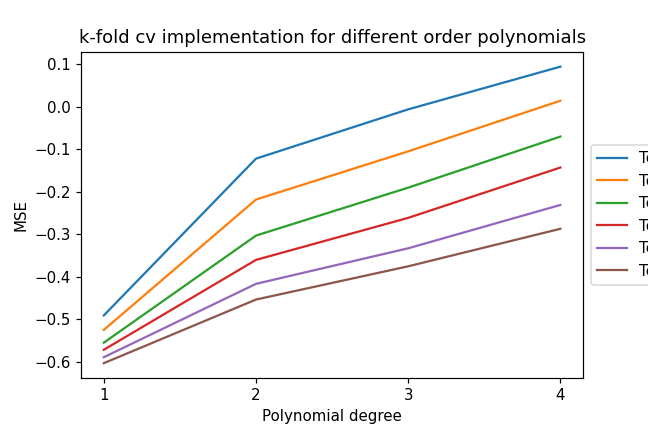

MSE on test-set : 
 [[0.32360056 0.29905168 0.27900301 0.26842037 0.25777392 0.24956025]
 [0.81548795 0.64744182 0.52559904 0.45649754 0.39730172 0.3624916 ]
 [1.42235577 1.1708927  0.95635021 0.79507236 0.64448074 0.56245795]
 [1.66220457 1.42279263 1.18292381 0.9891463  0.7910236  0.68542225]]


<ipython-input-8-7a78d83b1965>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


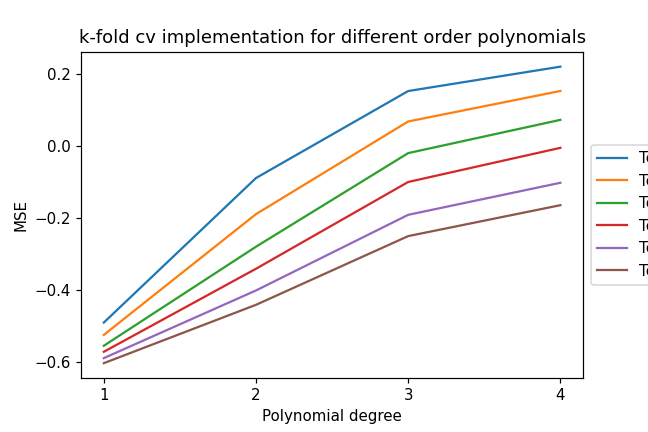

MSE on test-set : 
 [[0.32365449 0.29909097 0.27903158 0.2684437  0.2577929  0.24957526]
 [0.82250157 0.65236006 0.52878955 0.45879589 0.39888337 0.36365868]
 [1.65956778 1.408307   1.14143293 0.94839343 0.75404713 0.64025743]
 [2.10088912 1.91155194 1.6879837  1.4503985  1.17753052 1.02405225]]


<ipython-input-8-7a78d83b1965>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


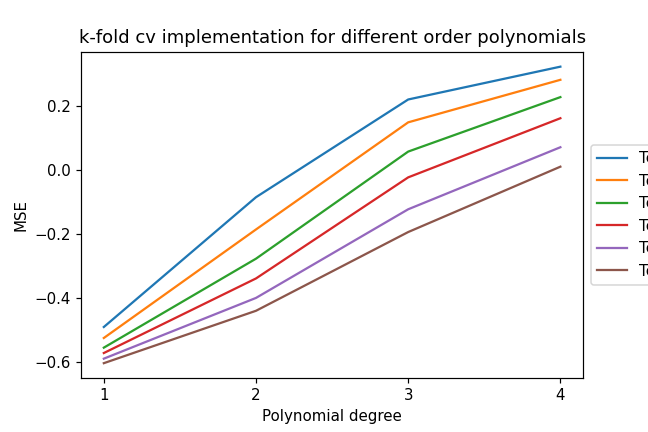

MSE on test-set : 
 [[0.32365989 0.29909491 0.27903444 0.26844603 0.2577948  0.24957676]
 [0.82321468 0.65286001 0.5291134  0.45902904 0.39904364 0.36377679]
 [1.69600439 1.44567906 1.17005685 0.97229573 0.77099256 0.65184082]
 [2.45909107 2.43928627 2.21876311 2.00715333 1.65078755 1.39172685]]


<ipython-input-8-7a78d83b1965>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


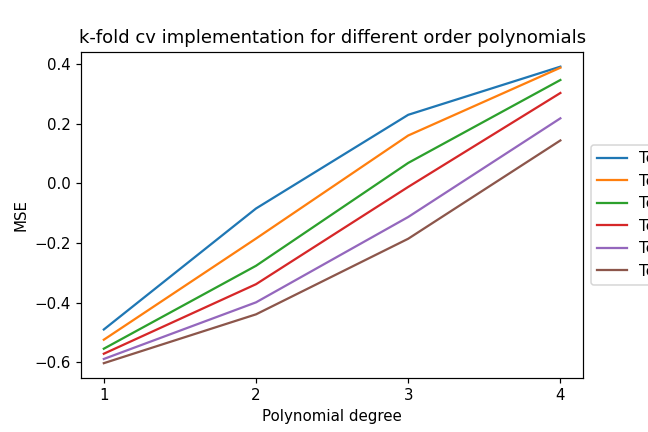

In [11]:
for lbd in Lambda:
    
    #define the input argumets for the solver 
    solver_args ={ 'fit_intercept': False, 'lbd': lbd}
    
    plot_kfold_implementation(features,labels , k_values, degree_values, scaling= True, add_noise= False, fig_name ='d_kfold_without_noise_lbd-'+str(lbd),solver = solver, **solver_args ) 
